In [1]:
#libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [104]:
df = pd.read_csv('train.csv')

---
## Functions for prepare data

In [105]:
# rename the columns names using lower case and replace space with '_'
def rename_columns(df):
    df.columns = [columns.lower().replace(" ","_") for columns in df.columns]
    return df

In [106]:
# add 1st_flr_sf and 2nd_flr_sf and create a new column total_sf
def create_total_sf(df):
    df['total_sf'] = df['1st_flr_sf'] + df['2nd_flr_sf']
    return df

In [107]:
# sum up all the qualites ( overll_qual + basement_qual + kitchen_qual + exter_qual)
def all_qual(df):
    df['bsmt_qual_fillna'] = df['bsmt_qual'].copy()
    df['bsmt_qual_fillna'].fillna(6,inplace=True)
    df['bsmt_qual_fillna'] = df['bsmt_qual_fillna'].map({'Po':2,'Fa':2,'TA':3,'Gd':4,'Ex':5,6:2})
    
    df['kitchen_qual_new'] = df['kitchen_qual'].map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    
    df['exter_qual_new'] = df['exter_qual'].map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    
    df['all_qual'] = df['overall_qual'] + df['bsmt_qual_fillna'] + df['kitchen_qual_new'] + df['exter_qual_new']
    return df

In [108]:
# def bsmt_qual_alter(df):
#     df['bsmt_qual_test1'] = df['bsmt_qual'].map(lambda x: 'Fa' if str(x) == 'nan' or x == 'Po' else x)
#     df.drop('bsmt_qual',axis = 1,inplace=True)
#     return df
# df = bsmt_qual_alter(df)

In [109]:
# def bsmt_full_bath_na(df):
#     df['bsmt_full_bath'].fillna(0,inplace=True)
#     return df
    
# df = bsmt_full_bath_na(df)

In [110]:
def garage_all(df):
    df['garage_cars'].fillna(2,inplace=True)
    df['garage_finish_new'] = df['garage_finish'].fillna('missing')
    df['garage_finish_new'] = df['garage_finish_new'].map({'missing':1,'Unf':2,'RFn':3,'Fin':4})
    df['garage_all'] = df['garage_finish_new'] + df['garage_cars']
    return df

In [111]:
def room_avg_size(df):
    df['room_avg_size'] = df['total_sf'] / (df['totrms_abvgrd'] + df['full_bath'] + 0.5*df['half_bath'] + df['kitchen_abvgr'])
    return df

In [112]:
def total_baths(df):
    df['total_baths'] = df['full_bath'] + 0.5*df['half_bath'] + 0.5* df['bsmt_full_bath'].fillna(0) + 0.5 *0.5* df['bsmt_half_bath'].fillna(0)
    return df


In [146]:
def fire_all(df):
    df['fireplace_qu_new'] = df['fireplace_qu'].fillna('missing')
    df['fireplace_qu_new'] = df['fireplace_qu_new'].map({'missing':1,'Po':1,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    df['fire_all'] = df['fireplace_qu_new'] + df['fireplaces']
    
    return df

In [11]:
# def kitchen_qual_alter(df):
#     df['kitchen_qual'] = df['kitchen_qual'].map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
#     return df
# df = kitchen_qual_alter(df)

In [12]:
# def central_air_convert(df):
#     df['central_air'] = df['central_air'].map({'Y':1,'N':0})
#     return df
# df = central_air_convert(df)

In [147]:
# using this function to do all the clean and engineering together
def clean_data(df,for_model='y'):
    df = rename_columns(df)
    df = create_total_sf(df)
    df = all_qual(df)
    df = garage_all(df)
    df = room_avg_size(df)
    df = total_baths(df)
    df = fire_all(df)
    
    if for_model == 'y':
        df = df[['all_qual','year_built','total_sf','total_baths','totrms_abvgrd','fire_all','garage_all','room_avg_size','saleprice']]
    else:
        df = df[['id','all_qual','year_built','total_sf','total_baths','totrms_abvgrd','fire_all','garage_all','room_avg_size']]
    return df

In [150]:
df_final = clean_data(df)

In [160]:
#high leverage outliers

df_final = df_final.drop(183)
df_final = df_final.drop(1628)

---


### Training Model

In [161]:
X = df_final.drop('saleprice',axis=1)
y = df_final['saleprice']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.85,random_state=42)

# log transform the saleprice
y_train = np.log(y_train)
y_test = np.log(y_test)
y_all = np.log(y)

In [162]:
pipe = Pipeline([
    ('sd',StandardScaler()),
    ('poly',PolynomialFeatures()),
#     ('el',ElasticNet())
#     ('lin',LinearRegression())
#     ('lso',Lasso())
    ('rg',Ridge())
])

In [163]:
pipe_params = {
    'sd__with_mean':[True,False],
    'sd__with_std':[True,False],
    'poly__interaction_only':[True],
    'poly__include_bias': [False],
#     'el__alpha':[0.001,0.01],
#     'el__l1_ratio':[0.5]
#     'lso__alpha':[0,0.1,0.5,0.6,0.9,1],
    'rg__alpha':[0.0001,0.001,0.01],
    'rg__normalize':[True]
}

In [164]:
pipe_gs = GridSearchCV(pipe,pipe_params,cv=10,verbose=1)

In [165]:
pipe_gs.fit(X_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sd', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('rg', Ridge())]),
             param_grid={'poly__include_bias': [False],
                         'poly__interaction_only': [True],
                         'rg__alpha': [0.0001, 0.001, 0.01],
                         'rg__normalize': [True],
                         'sd__with_mean': [True, False],
                         'sd__with_std': [True, False]},
             verbose=1)

In [166]:
pipe_gs.score(X_train,y_train),pipe_gs.score(X_test,y_test)

(0.8652566779088471, 0.8550699330284)

In [171]:
pipe_gs.best_estimator_

Pipeline(steps=[('sd', StandardScaler()),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('rg', Ridge(alpha=0.001, normalize=True))])

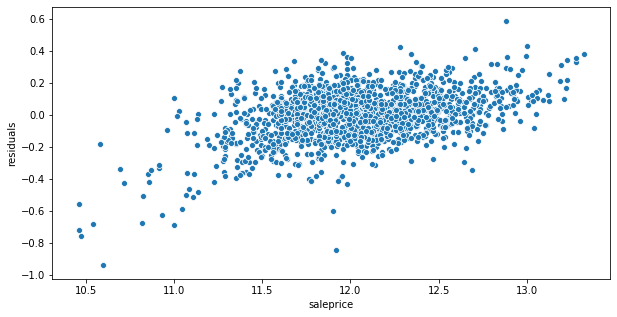

In [168]:
# visulize the residuals
preds = pipe_gs.predict(X_train)

resi = y_train - preds
plt.figure(figsize=(10,5))
sns.scatterplot(y_train,resi);
plt.ylabel('residuals');

Text(0, 0.5, 'predicted')

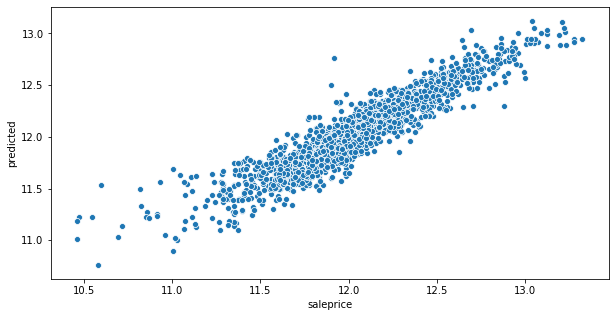

In [169]:
plt.figure(figsize=(10,5))
sns.scatterplot(y_train,preds);
plt.ylabel('predicted')

---
### using final hypy_parameters to fit all the data

In [170]:
pipe_gs.fit(X,y_all)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sd', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('rg', Ridge())]),
             param_grid={'poly__include_bias': [False],
                         'poly__interaction_only': [True],
                         'rg__alpha': [0.0001, 0.001, 0.01],
                         'rg__normalize': [True],
                         'sd__with_mean': [True, False],
                         'sd__with_std': [True, False]},
             verbose=1)

# Found 2 problems from the residuals plot:
* If saleprice is not log transformd, then the residual will increase when saleprice increases
* 2 high leverage outliers

In [658]:
# find the high leverage outlier
# train_vs_preds = pd.DataFrame({'y_train':y_train,'preds':preds,'resi':resi,'trans_back_train':np.exp(y_train)})

In [837]:
# train_vs_preds[train_vs_preds['resi'] == train_vs_preds['resi'].min()]

---
### check p values

In [836]:

# import statsmodels.api as sm
# sc = StandardScaler(with_mean=False,with_std=False)

# X_sd = sc.fit_transform(X)
# y_log = np.log(y)
# X_sd = sm.add_constant(X_sd)

# model = sm.OLS(y_log, X_sd)
# results = model.fit()

# results.summary()

---
## Make prediction on test data.

In [172]:
df_test = pd.read_csv('test.csv')
df_final_test = clean_data(df_test,for_model='n')
df_final_test = df_final_test.sort_values(by='id')

In [173]:
# finished sorting, drop id column
X_final_test = df_final_test.drop('id',axis=1)

In [174]:
# make prediction base on previous model
y_final_test = pipe_gs.predict(X_final_test)

In [175]:
# log transform back and convert to DataFrame
y_final_test_df = pd.DataFrame(np.exp(y_final_test))

In [176]:
df_final_test_id = df_final_test[['id']].reset_index(drop=True)

In [177]:
# concat the id column and prediction column
final_answear = pd.concat([df_final_test_id,y_final_test_df],axis=1)
final_answear.columns=['Id','SalePrice']

In [178]:
# export to csv file
final_answear.to_csv('second_submission.csv',index=False)

In [143]:
df_new = df.copy()

df_new['fireplace_qu_new'] = df_new['fireplace_qu'].fillna('missing')
df_new['fireplace_qu_new'] = df_new['fireplace_qu_new'].map({'missing':1,'Po':1,'Fa':1,'TA':2,'Gd':3,'Ex':4})
df_new['fire_product'] = df_new['fireplace_qu_new'] * df_new['fireplaces']
df_new['fire_sum'] = df_new['fireplace_qu_new'] + df_new['fireplaces']
# df_new['garage_all'] = df_new['garage_finish_new'] + df['garage_cars']

In [135]:
df['fireplace_qu'].value_counts(dropna=False)

NaN    1000
Gd      523
TA      407
Fa       59
Po       31
Ex       31
Name: fireplace_qu, dtype: int64

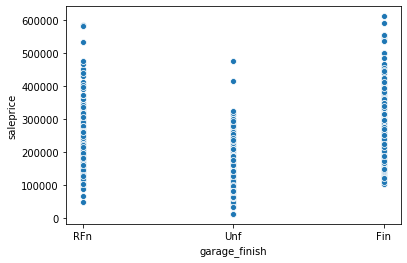

In [87]:
sns.scatterplot(df['garage_finish'],df['saleprice'])

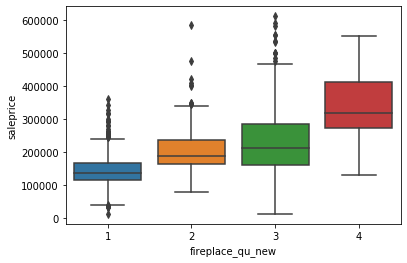

In [140]:
sns.boxplot(df_new['fireplace_qu_new'],df_new['saleprice'])

In [141]:
df_new[['saleprice','fireplace_qu_new']].corr()

,saleprice,fireplace_qu_new
saleprice,1.000000,0.541185
fireplace_qu_new,0.541185,1.000000


In [142]:
df_new[['saleprice','fireplaces']].corr()

,saleprice,fireplaces
saleprice,1.000000,0.471093
fireplaces,0.471093,1.000000


In [144]:
df_new[['saleprice','fire_sum']].corr()

,saleprice,fire_sum
saleprice,1.000000,0.546977
fire_sum,0.546977,1.000000


In [145]:
df_new[['saleprice','fire_product']].corr()

,saleprice,fire_product
saleprice,1.000000,0.524082
fire_product,0.524082,1.000000
